<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Raleway:wght@100&display=swap" rel="stylesheet">

<h1 style="text-transform: uppercase; text-align: center; font-weight: 100;">
Regression in Tensorflow using RNN</h1>
<p style="text-align: center; font-weight: 100;">Predicting Volkswagen car prices</p><br/>

Project requirements:
- Only requirement is: minimum 10k rows
- Any type of neural network - classical but convolutional and recurrent, better grade
- Presentation of project, beside practical questions about model there would be also theoretical.
The topic is free.

Theory required for project presentation:
- Practical side.
- Discuss the scheme of an artificial neuron.
- Activation function, why it is so important.
- Explain how does neuron learn - steps, algorithm?
- How does basic neural network work? (The more you know the better, as well as more complex).
- Discuss the algorithm of neural network using backpropagation learning method. (metoda wstecznej propagacji błędów)
- What subsets and why are the data divided into?
Knowledge of ML, statistics.

Data source: data were taken from the popular Polish automotive website Otomoto (https://www.otomoto.pl/).
https://www.asimovinstitute.org/neural-network-zoo/

1. Import libraries and create dataframe:

In [1]:
import sklearn as sl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import tensorflow as tf
import keras.utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# from model import VolkswagenModel
# from colorama import init, Fore, Style

print(f"numpy: {np.__version__}, pandas: {pd.__version__}, tensorflow: {tf.__version__}, matplotlib: {mpl.__version__}, seaborn: {sns.__version__}, statsmodels: {sm.__version__}, sklearn: {sl.__version__}")
print("Libs loaded.")

numpy: 1.23.2, pandas: 1.4.4, tensorflow: 2.11.0, matplotlib: 3.5.3, seaborn: 0.12.1, statsmodels: 0.13.2, sklearn: 1.0.2
Libs loaded.


In [2]:
data = pd.read_csv("./data/otomoto.csv")
df = pd.DataFrame(data)
df = df.drop(df.columns[0], axis=1)
df.columns = ['Price', 'Year', 'Mileage', 'Tank capacity', 'Fuel type', 'Model', 'Estimation']
print("Data technical info")
df.info()
df

Data technical info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14915 entries, 0 to 14914
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Price          14915 non-null  int64
 1   Year           14915 non-null  int64
 2   Mileage        14915 non-null  int64
 3   Tank capacity  14915 non-null  int64
 4   Fuel type      14915 non-null  int64
 5   Model          14915 non-null  int64
 6   Estimation     14915 non-null  int64
dtypes: int64(7)
memory usage: 815.8 KB


,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
0,24900,2010,166000,1390,1,16,0
1,16500,2007,194000,1968,7,39,0
2,364510,2022,5400,1968,7,8,0
3,9999,2005,196425,1390,1,35,2
4,39900,2010,227000,1968,7,32,0
...,...,...,...,...,...,...,...
14910,119500,2020,52000,1498,1,41,2
14911,31000,2002,511000,2461,7,9,0
14912,23500,2011,223000,1390,1,16,1
14913,29800,2012,190000,1598,7,16,2


In [3]:
description = df.describe()
description

,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
count,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000
mean,61420.578478,2012.424137,172886.681931,1755.932618,4.436876,27.893530,1.410325
std,61593.454821,6.757177,100170.759677,395.745487,2.952525,13.300906,1.071621
min,1500.000000,1958.000000,1.000000,77.000000,1.000000,1.000000,0.000000
25%,20000.000000,2008.000000,104343.000000,1498.000000,1.000000,16.000000,0.000000
50%,41999.000000,2013.000000,177000.000000,1896.000000,7.000000,32.000000,2.000000
75%,82900.000000,2018.000000,234350.000000,1968.000000,7.000000,39.000000,2.000000
max,570000.000000,2023.000000,700000.000000,5998.000000,7.000000,50.000000,3.000000


In [223]:
check = 14915
flag = True
for i in range(description.shape[1]):
    if description.iloc[0, i] != check:
        print("Number of occurrences of data is not equal for every label.")
        print(f"Problem at cell: (0, {i})")
        flag = False
        continue
    else:
        print(f"Checked: (0, {i})")

print("All columns passed" if flag == True else "Not passed")

Checked: (0, 0)
Checked: (0, 1)
Checked: (0, 2)
Checked: (0, 3)
Checked: (0, 4)
Checked: (0, 5)
Checked: (0, 6)
All columns passed


2. Clean data:

    Data was cleaned previously in 'scratchpad.py' file and now all the records are represented by integers(documentation of each column values is located in 'model.py' file). Values ​​of 0 represent an error in reading data. Column "Estimation" contains a lot of 0 values, but this is due to the fact that not every article on the website contained such information.

In [224]:
if df.isna().any().any():
    df = df.dropna()
    print("All rows with NaN values were dropped")
else:
    print("0 NaN values")

cols_to_check = df.columns[df.columns != 'Estimation']
if df[cols_to_check].eq(0).any().any():
    df[cols_to_check] = df[cols_to_check].replace(0, np.nan)
    print("All rows with 0 values were dropped")
else:
    print("0 zero values")

0 NaN values
0 zero values


In [225]:
df

,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
0,24900,2010,166000,1390,1,16,0
1,16500,2007,194000,1968,7,39,0
2,364510,2022,5400,1968,7,8,0
3,9999,2005,196425,1390,1,35,2
4,39900,2010,227000,1968,7,32,0
...,...,...,...,...,...,...,...
14910,119500,2020,52000,1498,1,41,2
14911,31000,2002,511000,2461,7,9,0
14912,23500,2011,223000,1390,1,16,1
14913,29800,2012,190000,1598,7,16,2



Getting know data, analyzing dependencies


Histograms

In [226]:
def make_hist(col_name, bins_val):
    min = df[col_name].min()
    max = df[col_name].max()
    print(f"Lowest {col_name} value: {min}. Highest {col_name} value: {max}.")
    plot_hist = df[col_name].plot.hist(bins=bins_val, grid=True)
    plot_hist.set_title(f"Represents number of cars for each production {col_name.upper()} category")
    plot_hist.set_xlabel(f"{col_name}")
    plot_hist.set_ylabel("Number of observations")
    plt.show()

Lowest Price value: 1500. Highest Price value: 570000.


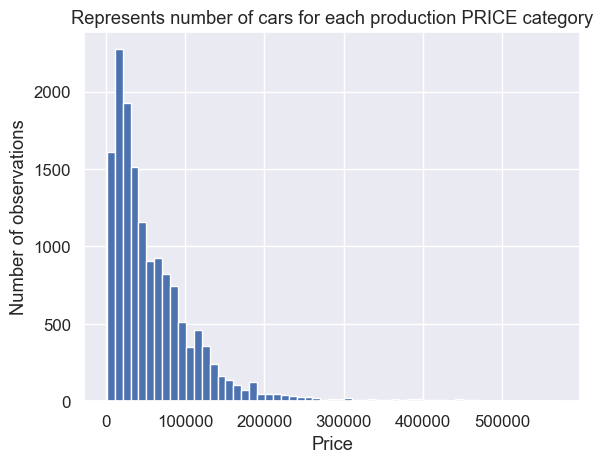

In [227]:
make_hist("Price", 57)

Lowest Year value: 1958. Highest Year value: 2023.


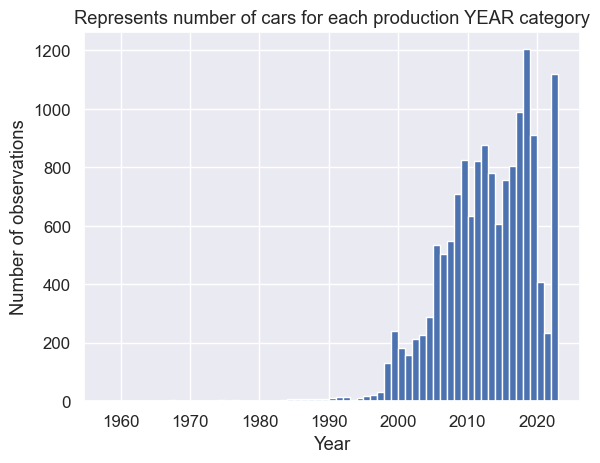

In [228]:
min = df["Year"].min()
max = df["Year"].max()
make_hist("Year", max-min)

Lowest Mileage value: 1. Highest Mileage value: 700000.


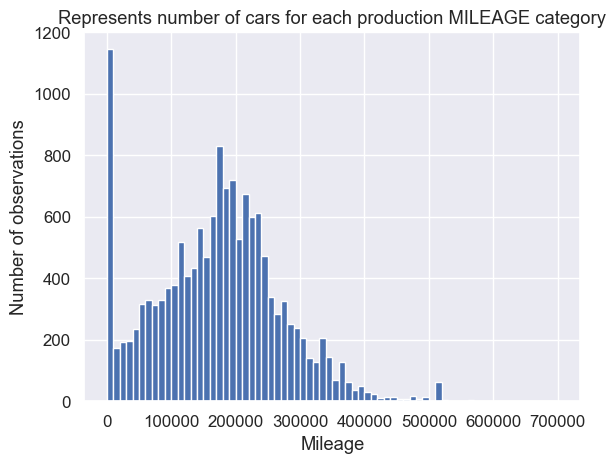

In [229]:
make_hist("Mileage", 70)

Lowest Tank capacity value: 77. Highest Tank capacity value: 5998.


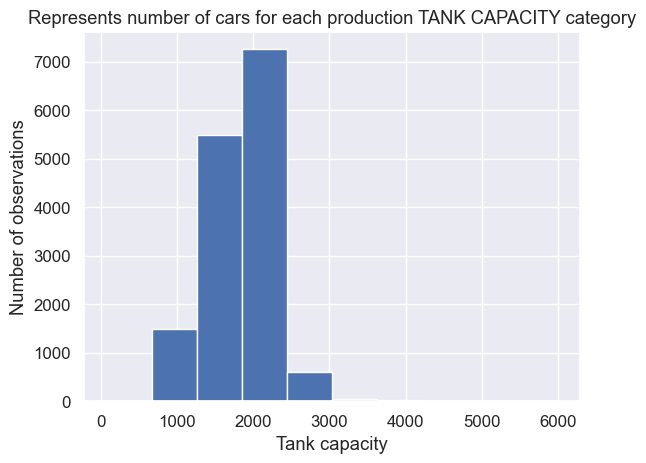

In [230]:
make_hist("Tank capacity", 10) # default bins = 10

# Trzeba jeszcze dopasować przedziały

Lowest Fuel type value: 1. Highest Fuel type value: 7.


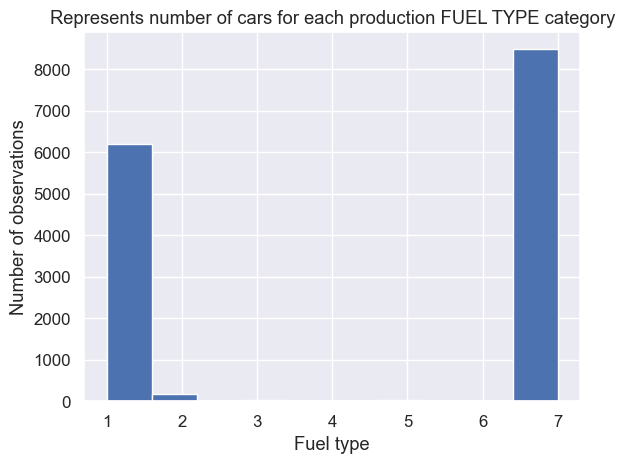

In [231]:
make_hist("Fuel type", 10) # default bins = 10

In [232]:
NO_cars_fuel = df['Fuel type'].value_counts().reset_index()
NO_cars_fuel = NO_cars_fuel.rename(columns={'index': 'type of fuel', 'Fuel type': 'NO of cars with specific fuel type'})
# NaN
# d = {"Benzyna": 1, "Benzyna+LPG": 2, "Benzyna+CNG": 3, "Elektryczny": 4, "Hybryda": 5, "Wodór": 6, "Diesel": 7}
# unique_values['name of fuel'] = unique_values['type of fuel'].map(d)
NO_cars_fuel

,type of fuel,NO of cars with specific fuel type
0,7,8483
1,1,6191
2,2,184
3,5,32
4,3,24
5,4,1


Lowest Model value: 1. Highest Model value: 50.


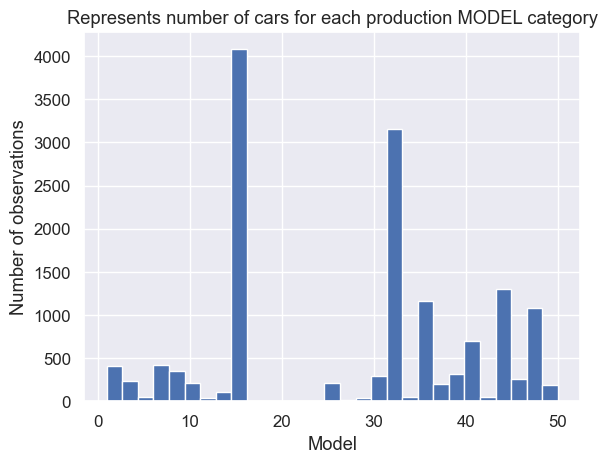

In [233]:
make_hist("Model", 29)

Lowest Estimation value: 0. Highest Estimation value: 3.


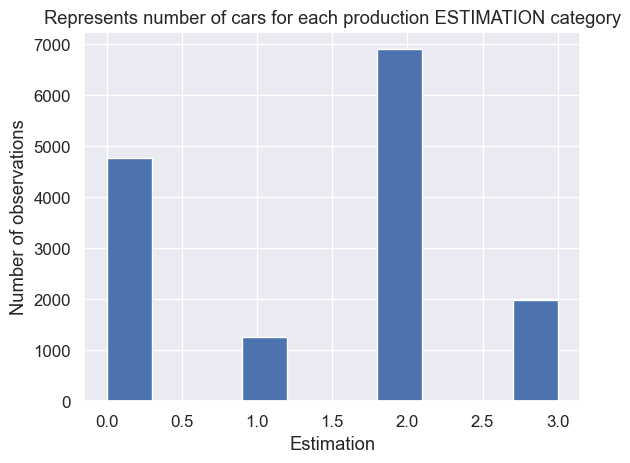

In [234]:
make_hist("Estimation", 10) # default bins = 10

Distribution of cars per column per certain category from column in numbers.

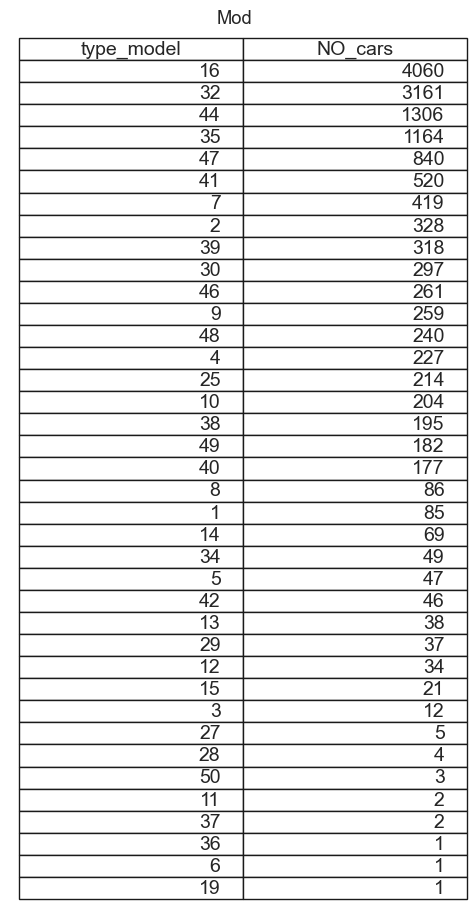

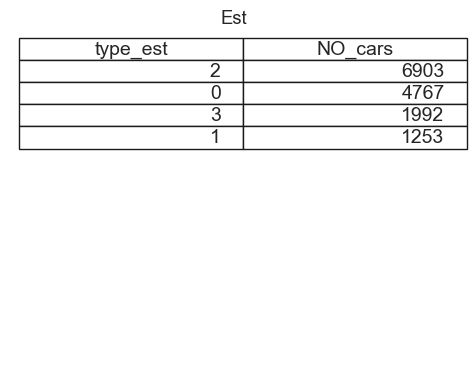

In [235]:
# pr = df['Price'].value_counts().reset_index()
# yr = df['Year'].value_counts().reset_index()
# mil = df['Mileage'].value_counts().reset_index()
# tank = df['Tank capacity'].value_counts().reset_index()
# fuel = df['Fuel type'].value_counts().reset_index()
mod = df['Model'].value_counts().reset_index()
est = df['Estimation'].value_counts().reset_index()

# pr = pr.rename(columns={'index': 'price_cat', 'Price': 'NO_cars'})
# yr = yr.rename(columns={'index': 'year_cat', 'Year': 'NO_cars'})
# mil = mil.rename(columns={'index': 'mileage_cat', 'Mileage': 'NO_cars'})
# tank = tank.rename(columns={'index': 'tank_capacity', 'Tank capacity': 'NO_cars'})
# fuel = fuel.rename(columns={'index': 'type_fuel', 'Fuel type': 'NO_cars'})
mod = mod.rename(columns={'index': 'type_model', 'Model': 'NO_cars'})
est = est.rename(columns={'index': 'type_est', 'Estimation': 'NO_cars'})

def create_table(table_data, table_title):
    fig = plt.figure()
    table = plt.table(cellText=table_data.values, colLabels=table_data.columns, loc='upper left')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 1.5)
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.title(table_title)
    plt.axis('off')
    return fig

# table1 = create_table(pr, "Pr")
# table2 = create_table(yr, "Yr")
# table3 = create_table(mil, "Mil")
# table4 = create_table(tank, "Tank")
# table5 = create_table(fuel, "Fuel")
table6 = create_table(mod, "Mod")
table7 = create_table(est, "Est")

Box plots

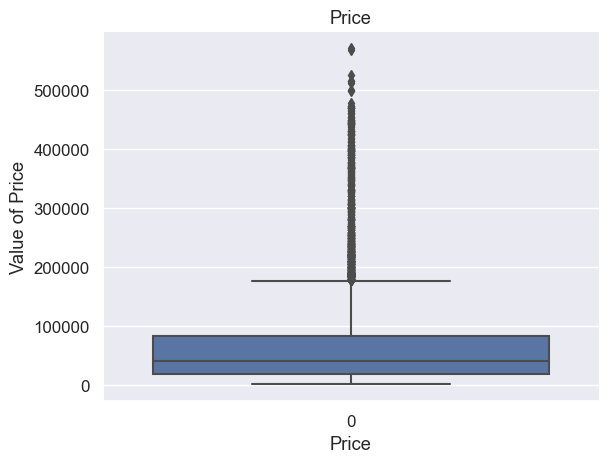

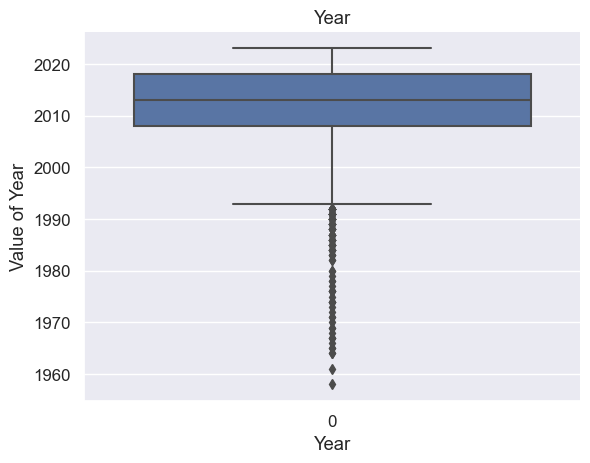

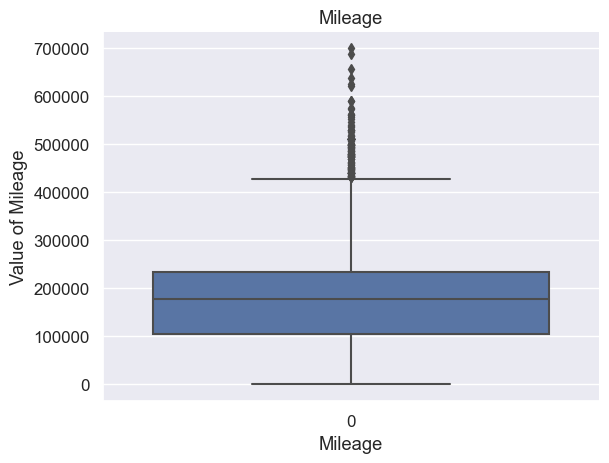

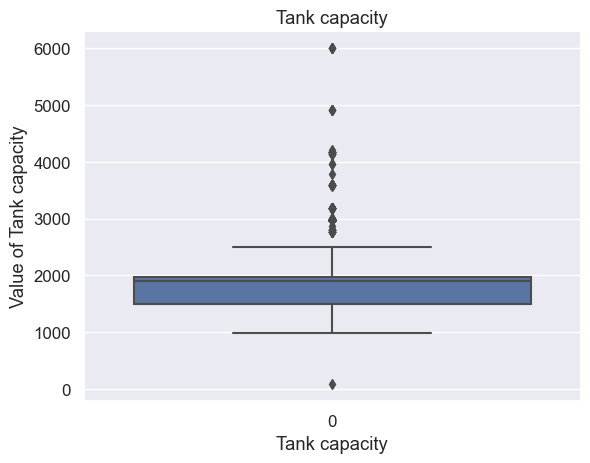

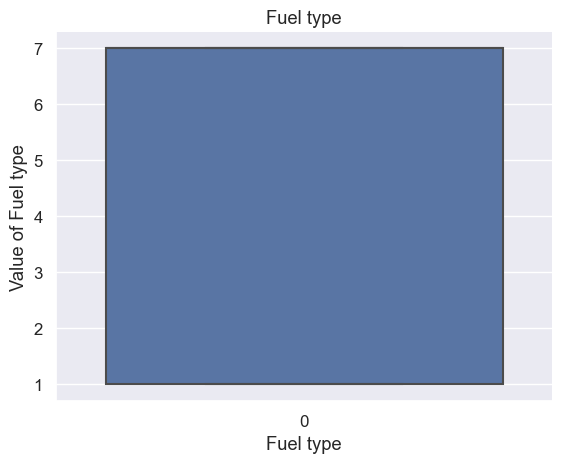

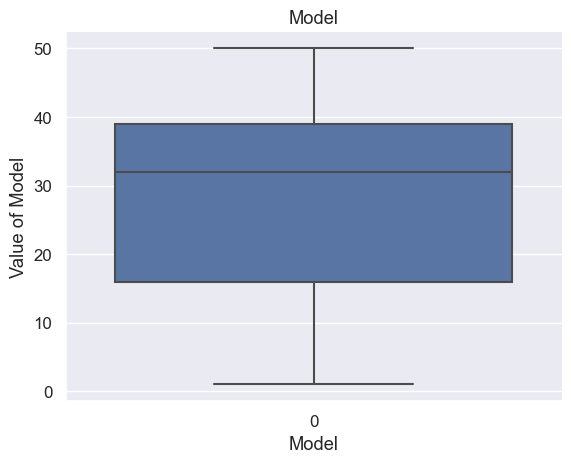

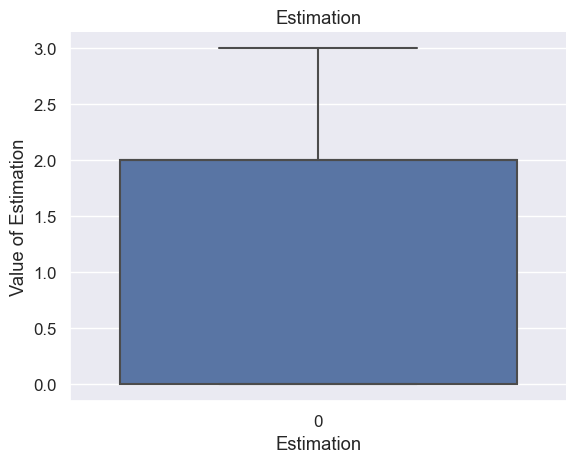

In [236]:
for i, column in enumerate(df.columns):
    fig, ax = plt.subplots()
    sns.boxplot(data=df[column], ax=ax).set(title=f"{column.upper()} boxplot", xlabel=f"{column}", ylabel=f"Value of {column}")
    ax.set_title(column)
    sns.despine()
    plt.show()

Heat Map

<AxesSubplot:>

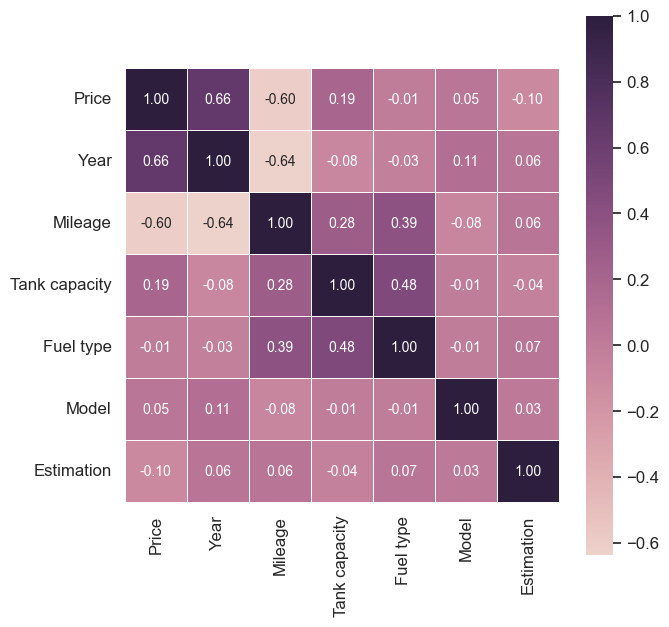

In [237]:
correlation_matrix = np.corrcoef(df.values.T)

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.1)
sns.heatmap(data=correlation_matrix, square=True, cbar=True, annot=True, annot_kws={'size': 10}, xticklabels=df.columns, yticklabels=df.columns, fmt=".2f", linewidth=.5, cmap=sns.cubehelix_palette(as_cmap=True))

Outlier detection

In [238]:
# https://www.kaggle.com/code/durgeshrao9993/removing-outliers-by-iqr-method

# # Interquartile Range (IQR)
# Q1 = data.quantile(0.25)
# Q3 = data.quantile(0.75)
# IQR = Q3 - Q1
# data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Calculate the z-scores of each column - measure that represents the number of standard deviations a data point is from the mean of the dataset
z_scores = (df - df.mean()) / df.std()
# Set the threshold for the z-score
threshold = 3
# Remove any rows where the z-score is greater than the threshold
df = df[(np.abs(z_scores) < threshold).all(axis=1)]
df

,Price,Year,Mileage,Tank capacity,Fuel type,Model,Estimation
0,24900,2010,166000,1390,1,16,0
1,16500,2007,194000,1968,7,39,0
3,9999,2005,196425,1390,1,35,2
4,39900,2010,227000,1968,7,32,0
5,139900,2020,149000,1968,7,32,3
...,...,...,...,...,...,...,...
14909,88999,2018,179960,1968,7,16,2
14910,119500,2020,52000,1498,1,41,2
14912,23500,2011,223000,1390,1,16,1
14913,29800,2012,190000,1598,7,16,2


In [239]:
print("14915 dropped to 14105 rows")

14915 dropped to 14105 rows


Boxplot / Heat Map - after outlier detection

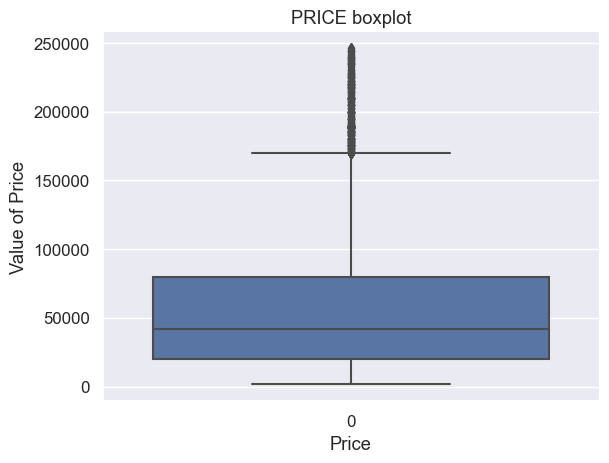

In [240]:
sns.boxplot(df['Price']).set(title="PRICE boxplot", xlabel="Price", ylabel="Value of Price")
sns.despine()

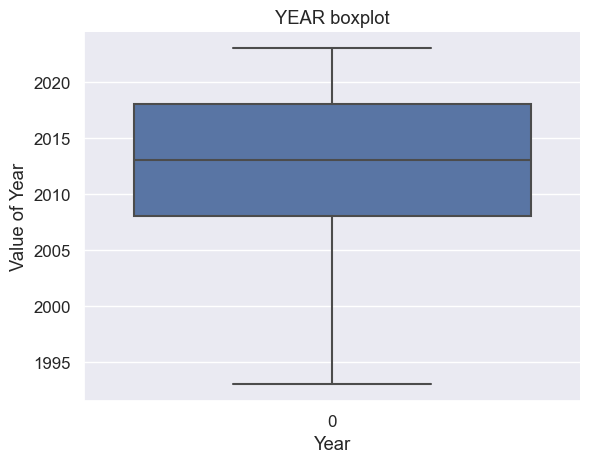

In [241]:
sns.boxplot(df['Year']).set(title="YEAR boxplot", xlabel="Year", ylabel="Value of Year")
sns.despine()

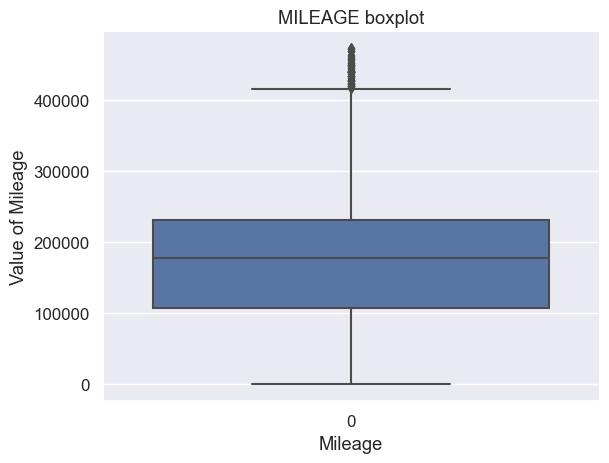

In [242]:
sns.boxplot(df['Mileage']).set(title="MILEAGE boxplot", xlabel="Mileage", ylabel="Value of Mileage")
sns.despine()

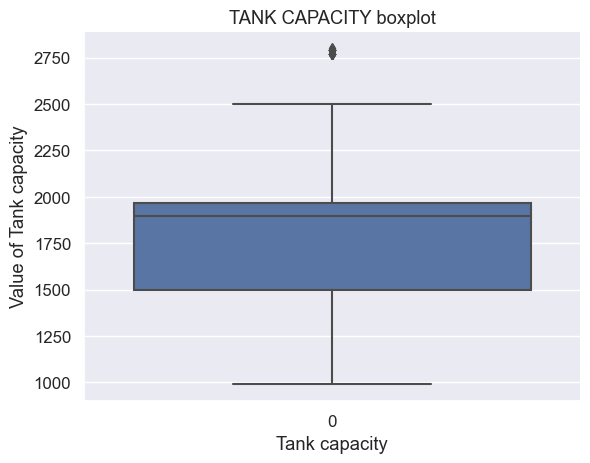

In [243]:
sns.boxplot(df['Tank capacity']).set(title="TANK CAPACITY boxplot", xlabel="Tank capacity", ylabel="Value of Tank capacity")
sns.despine()

<AxesSubplot:>

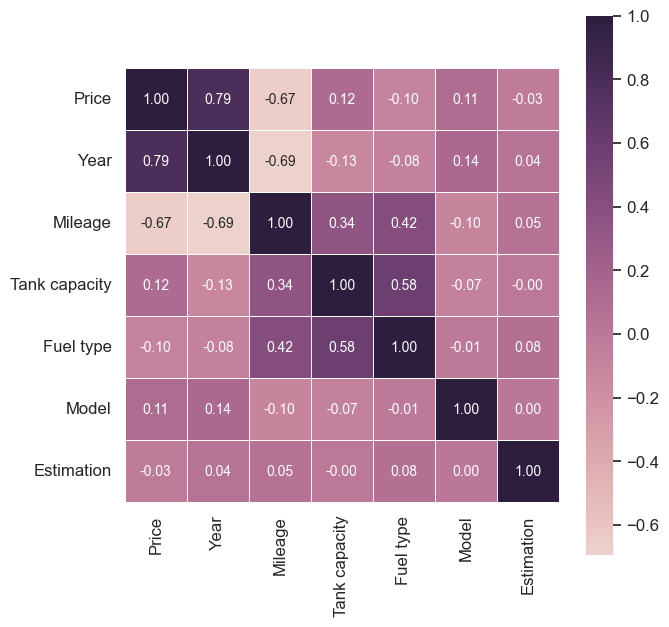

In [244]:
correlation_matrix = np.corrcoef(df.values.T)

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.1)
sns.heatmap(data=correlation_matrix, square=True, cbar=True, annot=True, annot_kws={'size': 10}, xticklabels=df.columns, yticklabels=df.columns, fmt=".2f", linewidth=.5, cmap=sns.cubehelix_palette(as_cmap=True))

Pair plot

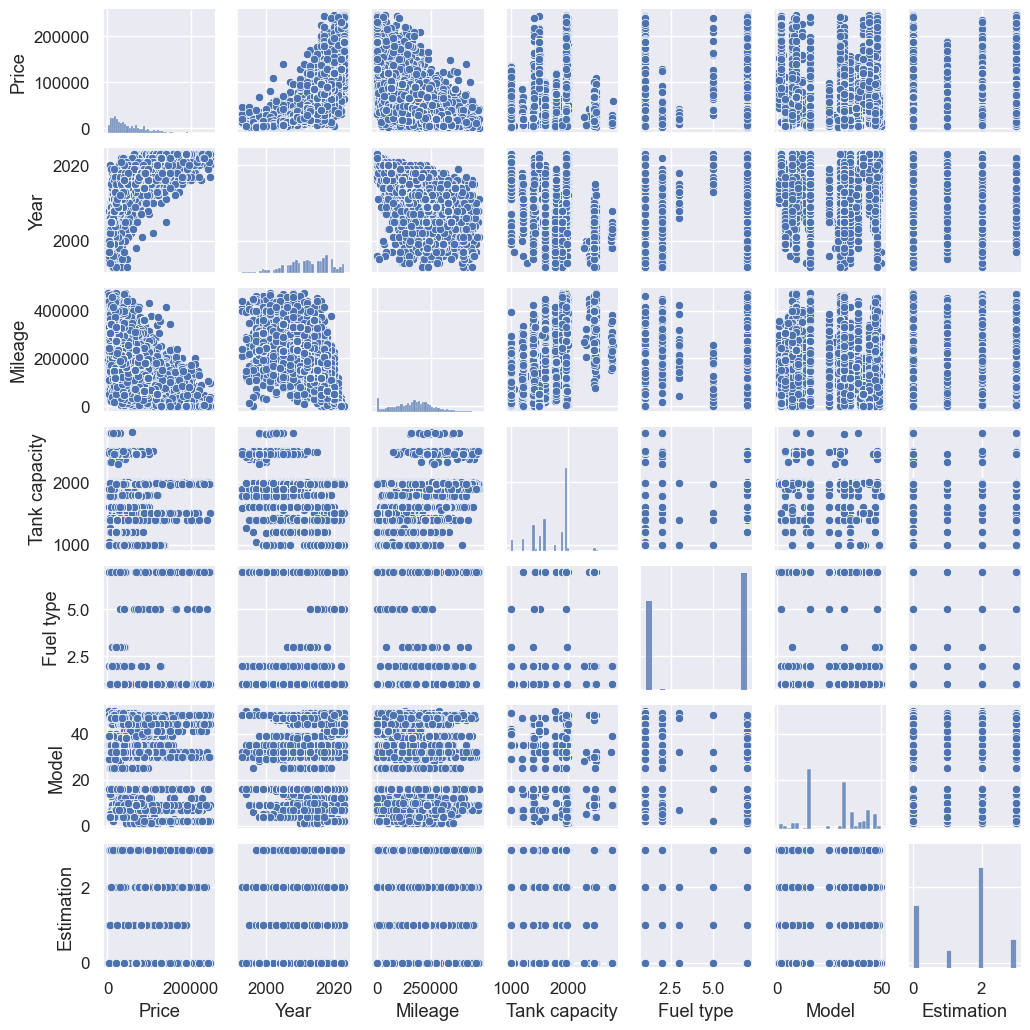

In [245]:
sns.pairplot(df, height=1.5)

Splitting data into sets

In [4]:
# SKLEARN

X = df.drop(['Price'], axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [5]:
# KERAS/TENSORFLOW

# data_size = len(df)
# test_size = int(data_size * 0.2)  # 20% danych przeznaczamy na zbiór testowy
# train_size = data_size - test_size
#
# data = tf.data.Dataset.from_tensor_slices((X.values, y.values))
# data = data.shuffle(buffer_size=data_size, reshuffle_each_iteration=True) # randomize data after each iteration (epoch)
#
# # Helps to optimize code by dividing datasets into batches, portion of data instead of individual processing.
# train_data = data.take(train_size).batch(32)
# test_data = data.skip(train_size).take(test_size).batch(32)
# X_train, y_train = next(iter(train_data))
# X_test, y_test = next(iter(test_data))
#
# # Print length of datasets portions
# print(f"X_train len = {len(X_train)}")
# print(f"y_train len = {len(y_train)}")
# print(f"X_test len = {len(X_test)}")
# print(f"y_test len = {len(y_test)}")
#
# # Print datasets portions
# # print('X_train = ', X_train)
# # print('y_train = ', y_train)
# # print('X_test = ', X_test)
# # print('y_test = ', y_test)

Model Architecture

In [6]:
# https://www.tensorflow.org/guide/keras/rnn?hl=pl
# https://www.ibm.com/topics/recurrent-neural-networks
# Pipelines


def LSTM_architecture(neurons_lstm, neurons_dense, activation, l2_val):
    model_LSTM = tf.keras.Sequential([
        tf.keras.layers.LSTM(neurons_lstm, input_shape=(1, X_train.shape[-1])),
        tf.keras.layers.Dense(neurons_dense, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_val)),
        tf.keras.layers.Dense(neurons_dense, activation=activation),
        tf.keras.layers.Dense(1)
    ])
    model_LSTM.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    return model_LSTM

def MLP_architecture(neurons_lstm, neurons_dense1, neurons_dense2, activation, l2_val):
    modelMLP = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_lstm, input_shape=(X_train.shape[1],), activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense1, activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense2, activation=activation),
        tf.keras.layers.Dense(1)
    ])
    return modelMLP

def GRU_architecture(neurons_lstm=128, neurons_dense=64, activation='relu', l2_val=0.01):
    model_GRU = tf.keras.Sequential([
        tf.keras.layers.GRU(neurons_lstm, input_shape=(1, X_train.shape[-1])),
        tf.keras.layers.Dense(neurons_dense, activation=activation , kernel_regularizer=tf.keras.regularizers.l2(l2_val)),
        tf.keras.layers.Dense(1)
    ])
    model_GRU.compile(
        optimizer='adam',
        loss='mse'
    )
    return model_GRU

def MLP_architecture_v2(neurons_lstm, neurons_dense1, neurons_dense2, neurons_dense3, neurons_dense4, activation, l2_val):
    modelMLPv2 = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_lstm, input_shape=(X_train.shape[1],), activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense1, activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense2, activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense3, activation=activation),
        tf.keras.layers.Dropout(l2_val),
        tf.keras.layers.Dense(neurons_dense4, activation=activation),
        tf.keras.layers.Dense(1)
    ])
    modelMLPv2.compile(loss='mse', optimizer='adam')
    return modelMLPv2


# Equivalent to:
# input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
# lstm_layer = tf.keras.layers.LSTM(64)(input_layer)
# dense_layer_1 = tf.keras.layers.Dense(32, activation='relu')(lstm_layer)
# output_layer = tf.keras.layers.Dense(1)(dense_layer_1)
# model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

Normalize / Scale

In [7]:
# Normalization - we change the distribution of data, not the range of data like it is done in scaling. The point is to change observations so that they can be described as a normal distribution.
# Normalization should be done after splitting into train and test data sets.
# https://keras.io/api/layers/preprocessing_layers/numerical/normalization/
# fit_transform() is used to learn and apply the transformation to the data in one step, whereas transform() is used to apply the transformation to new data using the learned parameters.

# If you are using a regression model and want to predict a continuous target variable (i.e., y), then you should scale both the input features (X) and the target variable (y). This is because scaling both the input features and target variable will help the model to learn better and converge faster.
# If you are using a classification model and want to predict a binary or categorical target variable, then you do not need to scale the target variable (y). This is because scaling does not change the nature of the target variable, and most classification algorithms do not depend on the scale of the target variable.


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
print("Normalization done")

Normalization done


Compile and train training the model

In [8]:
# Reshape 2D array into 3D tensor
X_train_3D = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3D = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [7]:
model_LSTM = LSTM_architecture(neurons_lstm=64, neurons_dense=32, activation='relu', l2_val=0.01)


# "History" object contains information about the training process, including the loss and metrics values recorded during training and validation at each epoch.
history_LSTM = model_LSTM.fit(
    X_train_3D,
    y_train_scaled,
    epochs=5,
    validation_data=(X_test_3D, y_test_scaled),
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
373/373 [==============================] - 8s 8ms/step - loss: 0.4760 - val_loss: 0.2415
Epoch 2/5
373/373 [==============================] - 2s 4ms/step - loss: 0.2332 - val_loss: 0.1929
Epoch 3/5
373/373 [==============================] - 2s 4ms/step - loss: 0.1998 - val_loss: 0.1844
Epoch 4/5
373/373 [==============================] - 1s 4ms/step - loss: 0.1885 - val_loss: 0.1706
Epoch 5/5
373/373 [==============================] - 1s 4ms/step - loss: 0.1803 - val_loss: 0.2189


In [34]:
model_MLP = MLP_architecture(neurons_lstm=128, neurons_dense1=64, neurons_dense2=32, activation='relu', l2_val=0.01)
model_MLP.compile(
    optimizer='adam',
    loss='mse'
)
# "History" object contains information about the training process, including the loss and metrics values recorded during training and validation at each epoch.
history_MLP = model_MLP.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=5,
    validation_data=(X_test_scaled, y_test_scaled),
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
373/373 [==============================] - 3s 4ms/step - loss: 0.2511 - val_loss: 0.1717
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.1673 - val_loss: 0.1475
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.1577 - val_loss: 0.1467
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.1545 - val_loss: 0.1451
Epoch 5/5
373/373 [==============================] - 1s 3ms/step - loss: 0.1490 - val_loss: 0.1401


In [35]:
model_GRU = GRU_architecture(neurons_lstm=128, neurons_dense=64, activation='relu', l2_val=0.01)


# "History" object contains information about the training process, including the loss and metrics values recorded during training and validation at each epoch.
history_GRU = model_GRU.fit(
    X_train_3D,
    y_train_scaled,
    epochs=5,
    validation_data=(X_test_3D, y_test_scaled),
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
373/373 [==============================] - 5s 6ms/step - loss: 0.5117 - val_loss: 0.2531
Epoch 2/5
373/373 [==============================] - 1s 4ms/step - loss: 0.2352 - val_loss: 0.2251
Epoch 3/5
373/373 [==============================] - 2s 4ms/step - loss: 0.2064 - val_loss: 0.1836
Epoch 4/5
373/373 [==============================] - 2s 4ms/step - loss: 0.1956 - val_loss: 0.1934
Epoch 5/5
373/373 [==============================] - 2s 4ms/step - loss: 0.1871 - val_loss: 0.1710


In [36]:
model_MLP_more_neurons = MLP_architecture(neurons_lstm=128, neurons_dense1=128, neurons_dense2=64, activation='relu', l2_val=0.01)
model_MLP_more_neurons.compile(
optimizer = 'adam',
loss = 'mse'
)
# "History" object contains information about the training process, including the loss and metrics values recorded during training and validation at each epoch.
history_MLP_more_neurons = model_MLP_more_neurons.fit(
X_train_scaled,
y_train_scaled,
epochs = 5,
validation_data = (X_test_scaled, y_test_scaled),
batch_size = 32,
validation_split = 0.2
)

Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.2276 - val_loss: 0.1497
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.1669 - val_loss: 0.1494
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.1532 - val_loss: 0.1462
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.1502 - val_loss: 0.1391
Epoch 5/5
373/373 [==============================] - 1s 3ms/step - loss: 0.1469 - val_loss: 0.1336


In [9]:
model_MLP_v2 = MLP_architecture_v2(neurons_lstm=128, neurons_dense1=64, neurons_dense2=32, neurons_dense3=16, neurons_dense4=16, activation='relu', l2_val=0.01)
model_MLP_v2.compile(
    optimizer='adam',
    loss='mse'
)
history_MLP_v2 = model_MLP_v2.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=1,
    validation_data=(X_test_scaled, y_test_scaled),
    batch_size=32,
    validation_split=0.2
)

373/373 [==============================] - 5s 4ms/step - loss: 0.2744 - val_loss: 0.1522


In [38]:
# We could also add combination of MLP and CNN.

Evaluating the model

In [39]:
print("---------- LSTM MODEL ----------")

# ocena modelu na danych testowych
test_loss_LSTM = model_LSTM.evaluate(X_test_3D, y_test_scaled)
train_loss_LSTM = model_LSTM.evaluate(X_train_3D, y_train_scaled)

# wyświetlenie wyników
print(f'Testing Loss =  {test_loss_LSTM:.4f}')
print(f'Training Loss = {train_loss_LSTM:.4f}')

y_pred_scaled_LSTM = model_LSTM.predict(X_test_3D)
y_pred_LSTM = scaler.inverse_transform(y_pred_scaled_LSTM)
y_test = scaler.inverse_transform(y_test_scaled)
mse_LSTM = mean_squared_error(y_test, y_pred_LSTM)
mae_LSTM = mean_absolute_error(y_test, y_pred_LSTM)
print(f'MSE =  {mse_LSTM:.4f}')
print(f'MAE =  {mae_LSTM:.4f}')

---------- LSTM MODEL ----------
373/373 [==============================] - 1s 2ms/step - loss: 0.1722
Testing Loss =  0.1645
Training Loss = 0.1722
94/94 [==============================] - 1s 2ms/step
MSE =  570924376.4671
MAE =  12992.2393


In [40]:
print("---------- MLP MODEL ----------")

# Evaluate model on test data
test_loss_MLP = model_MLP.evaluate(X_test_scaled, y_test_scaled)
train_loss_MLP = model_MLP.evaluate(X_train_scaled, y_train_scaled)

# Display results
print(f'Testing Loss =  {test_loss_MLP:.4f}')
print(f'Training Loss = {train_loss_MLP:.4f}')

y_pred_scaled_MLP = model_MLP.predict(X_test_scaled)
y_pred_MLP = scaler.inverse_transform(y_pred_scaled_MLP)
y_test = scaler.inverse_transform(y_test_scaled)
mse_MLP = mean_squared_error(y_test, y_pred_MLP)
mae_MLP = mean_absolute_error(y_test, y_pred_MLP)
print(f'MSE =  {mse_MLP:.4f}')
print(f'MAE =  {mae_MLP:.4f}')

---------- MLP MODEL ----------
373/373 [==============================] - 1s 2ms/step - loss: 0.1417
Testing Loss =  0.1401
Training Loss = 0.1417
94/94 [==============================] - 0s 2ms/step
MSE =  533470925.8339
MAE =  12122.3378


In [41]:
print("---------- GRU MODEL ----------")
# evaluate the model on test data
test_loss_GRU = model_GRU.evaluate(X_test_3D, y_test_scaled)
train_loss_GRU = model_GRU.evaluate(X_train_3D, y_train_scaled)

# display the results
print(f'Testing Loss =  {test_loss_GRU:.4f}')
print(f'Training Loss = {train_loss_GRU:.4f}')

y_pred_scaled_GRU = model_GRU.predict(X_test_3D)
y_pred_GRU = scaler.inverse_transform(y_pred_scaled_GRU)
y_test = scaler.inverse_transform(y_test_scaled)
mse_GRU = mean_squared_error(y_test, y_pred_GRU)
mae_GRU = mean_absolute_error(y_test, y_pred_GRU)
print(f'MSE =  {mse_GRU:.4f}')
print(f'MAE =  {mae_GRU:.4f}')

---------- GRU MODEL ----------
373/373 [==============================] - 1s 2ms/step - loss: 0.1804
Testing Loss =  0.1710
Training Loss = 0.1804
94/94 [==============================] - 1s 2ms/step
MSE =  588759918.9990
MAE =  13398.7182


In [42]:
print("---------- MLP_more_neurons MODEL ----------")

# Evaluate model on test data
test_loss_MLP_n = model_MLP_more_neurons.evaluate(X_test_scaled, y_test_scaled)
train_loss_MLP_n = model_MLP_more_neurons.evaluate(X_train_scaled, y_train_scaled)

# Display results
print(f'Testing Loss =  {test_loss_MLP_n:.4f}')
print(f'Training Loss = {train_loss_MLP_n:.4f}')

y_pred_scaled_MLP_n = model_MLP_more_neurons.predict(X_test_scaled)
y_pred_MLP_n = scaler.inverse_transform(y_pred_scaled_MLP_n)
y_test = scaler.inverse_transform(y_test_scaled)
mse_MLP_n = mean_squared_error(y_test, y_pred_MLP_n)
mae_MLP_n = mean_absolute_error(y_test, y_pred_MLP_n)
print(f'MSE =  {mse_MLP_n:.4f}')
print(f'MAE =  {mae_MLP_n:.4f}')

---------- MLP_more_neurons MODEL ----------
373/373 [==============================] - 1s 2ms/step - loss: 0.1325
Testing Loss =  0.1336
Training Loss = 0.1325
94/94 [==============================] - 0s 2ms/step
MSE =  508663529.6225
MAE =  11508.5760


In [43]:
print("---------- MLP_v2 MODEL ----------")

# Evaluate model on test data
test_loss_MLP_v2 = model_MLP_v2.evaluate(X_test_scaled, y_test_scaled)
train_loss_MLP_v2 = model_MLP_v2.evaluate(X_train_scaled, y_train_scaled)

# Display results
print(f'Testing Loss =  {test_loss_MLP_v2:.4f}')
print(f'Training Loss = {train_loss_MLP_v2:.4f}')

y_pred_scaled_MLP_v2 = model_MLP_v2.predict(X_test_scaled)
y_pred_MLP_v2 = scaler.inverse_transform(y_pred_scaled_MLP_v2)
y_test = scaler.inverse_transform(y_test_scaled)
mse_MLP_v2 = mean_squared_error(y_test, y_pred_MLP_v2)
mae_MLP_v2 = mean_absolute_error(y_test, y_pred_MLP_v2)
print(f'MSE =  {mse_MLP_v2:.4f}')
print(f'MAE =  {mae_MLP_v2:.4f}')

---------- MLP_v2 MODEL ----------
373/373 [==============================] - 1s 2ms/step - loss: 0.1369
Testing Loss =  0.1407
Training Loss = 0.1369
94/94 [==============================] - 0s 1ms/step
MSE =  535542600.3912
MAE =  11531.7663


Metrics plots

In [44]:
def metrics_plots(model_history, y_pred_model, mae_model, mse_model, model_name):
    # Train and validation loss history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    # Plot the training and validation loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss FOR {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Predictions vs. actual values
    plt.scatter(y_test, y_pred_model, color='red', label='Predicted')
    plt.scatter(y_test, y_test, color='blue', label='Actual')
    plt.title(f'Predictions vs. Actual Values FOR {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

    # Plot the Mean Absolute Error
    plt.scatter(y_test, abs(y_pred_model - y_test), color='cyan', label='Absolute Error')
    plt.axhline(y=mae_model, color='brown', linestyle='--', label='MAE')
    plt.title(f'Mean Absolute Error FOR {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Absolute Error')
    plt.legend()
    plt.show()

    # Plot the Mean Squared Error
    plt.scatter(y_test, (y_pred_model - y_test)**2, color='purple', label='Squared Error')
    plt.axhline(y=mse_model, color='yellow', linestyle='--', label='MSE')
    plt.title(f'Mean Squared Error FOR {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Squared Error')
    plt.legend()
    plt.show()

# https://www.baeldung.com/cs/training-validation-loss-deep-learning

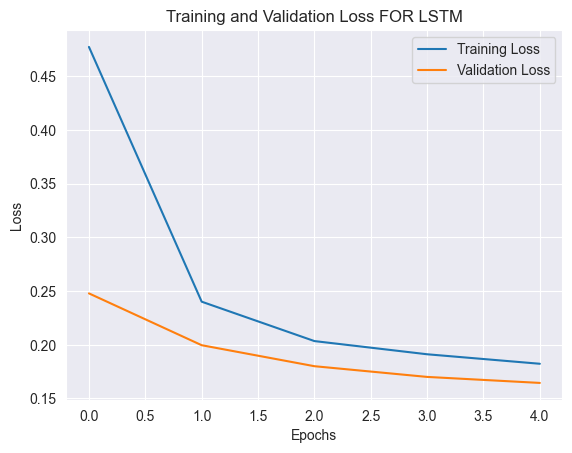

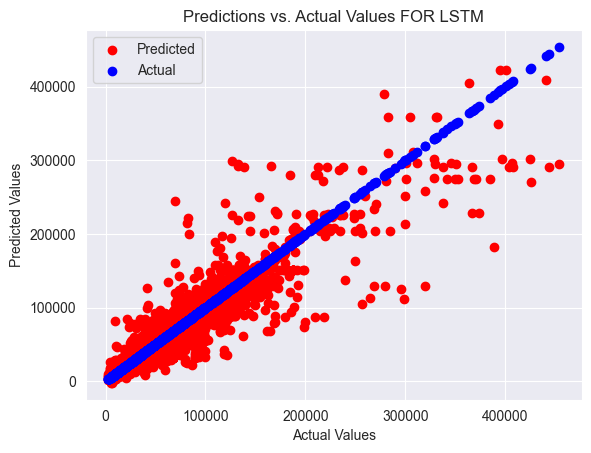

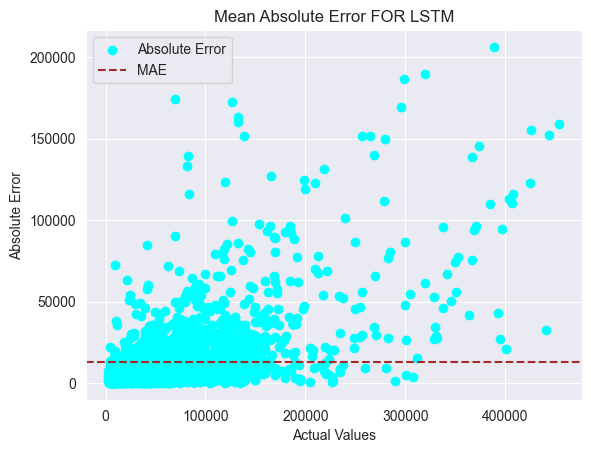

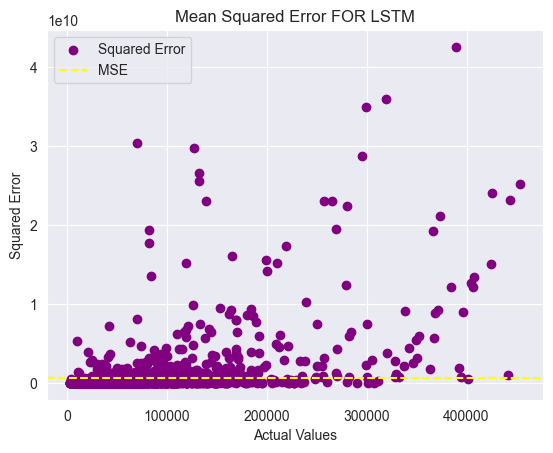

In [45]:
metrics_plots(history_LSTM, y_pred_LSTM, mae_LSTM, mse_LSTM, "LSTM")

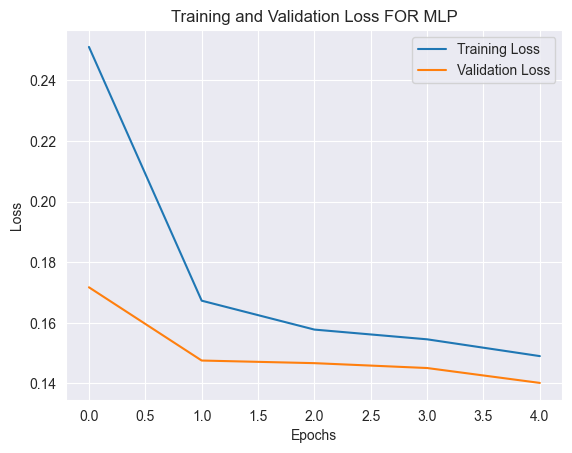

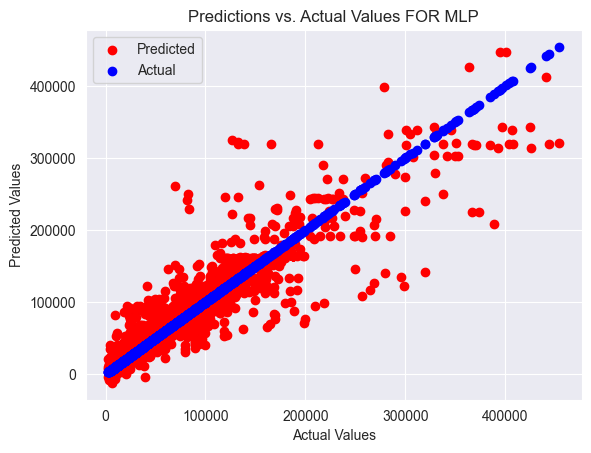

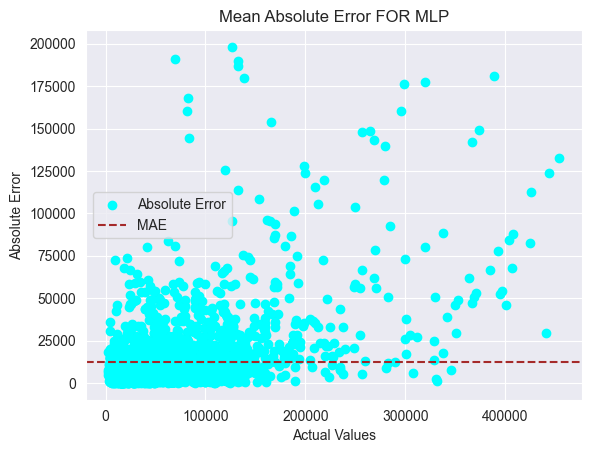

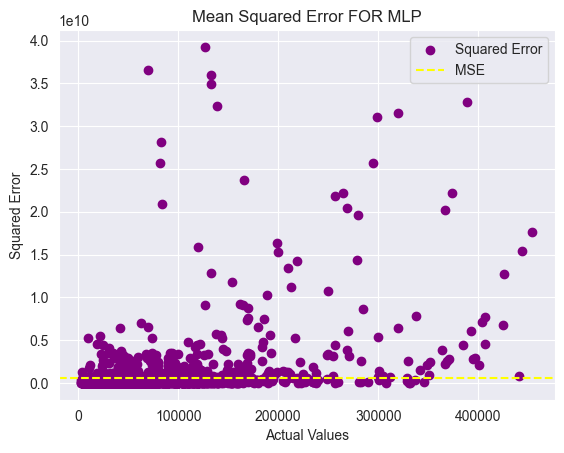

In [46]:
metrics_plots(history_MLP, y_pred_MLP, mae_MLP, mse_MLP, "MLP")

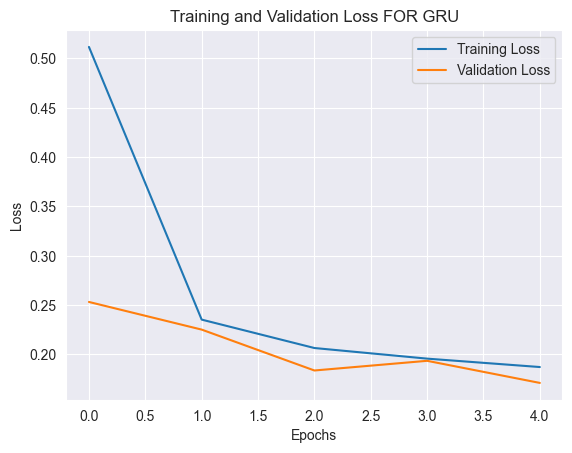

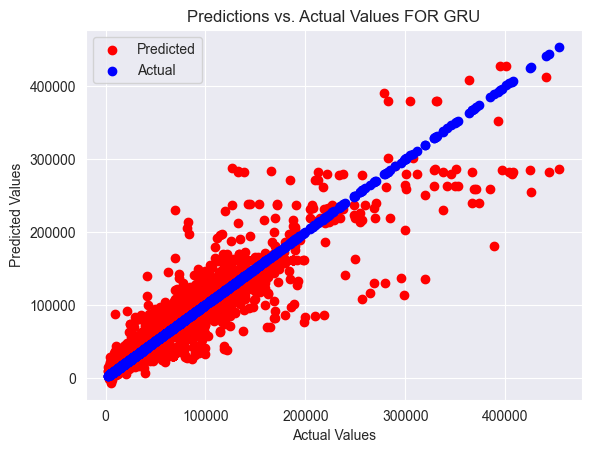

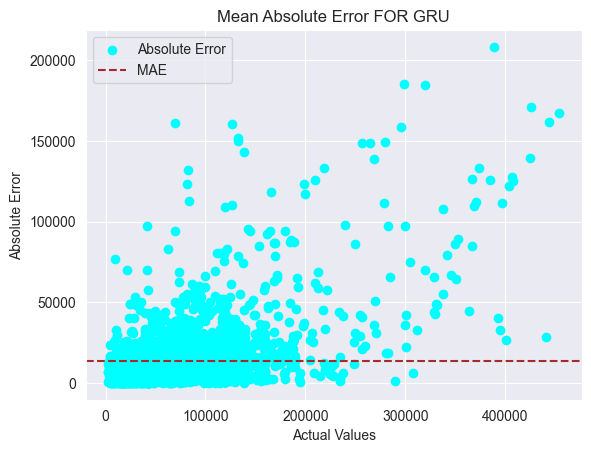

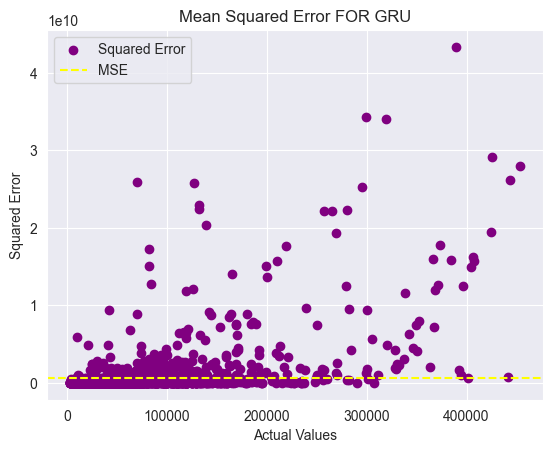

In [47]:
metrics_plots(history_GRU, y_pred_GRU, mae_GRU, mse_GRU, "GRU")

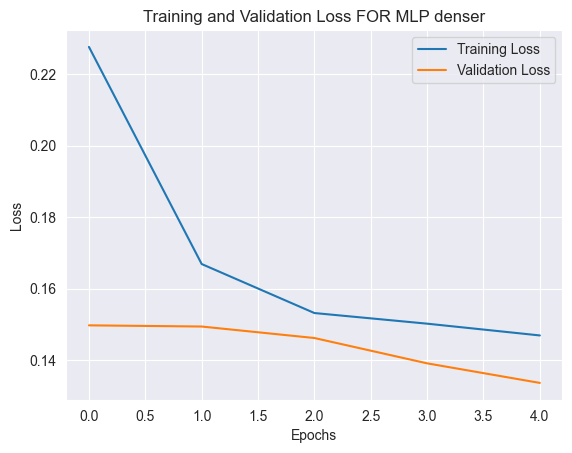

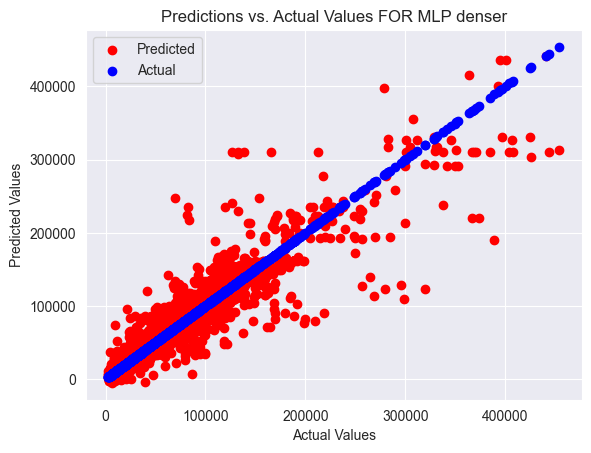

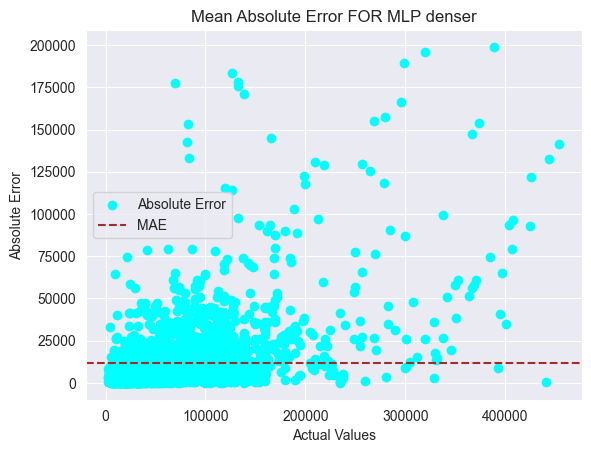

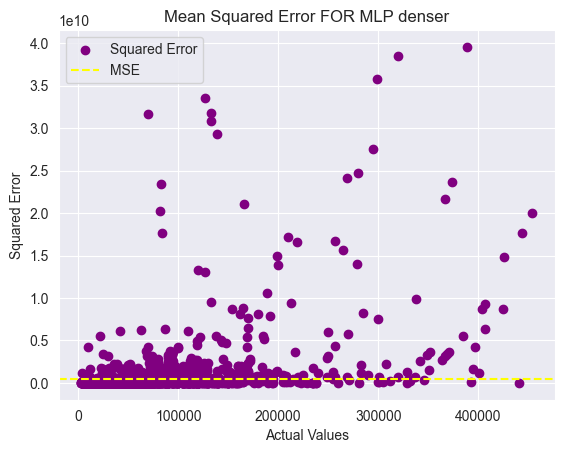

In [48]:
metrics_plots(history_MLP_more_neurons, y_pred_MLP_n, mae_MLP_n, mse_MLP_n, "MLP denser")

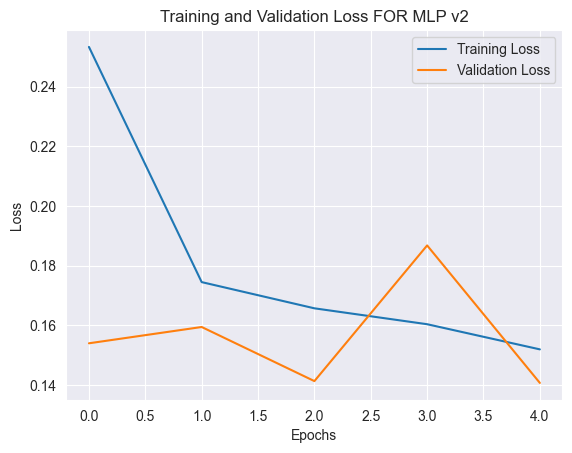

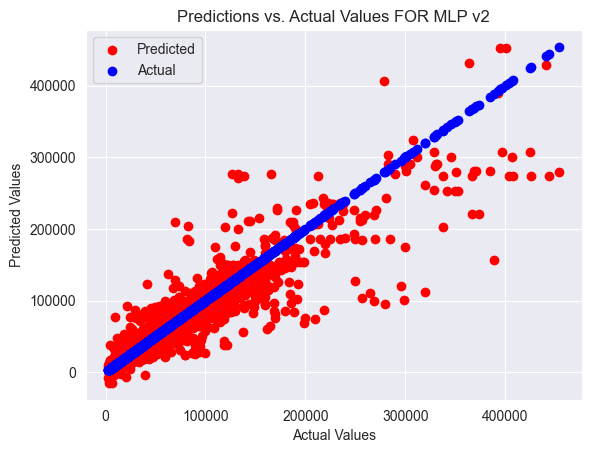

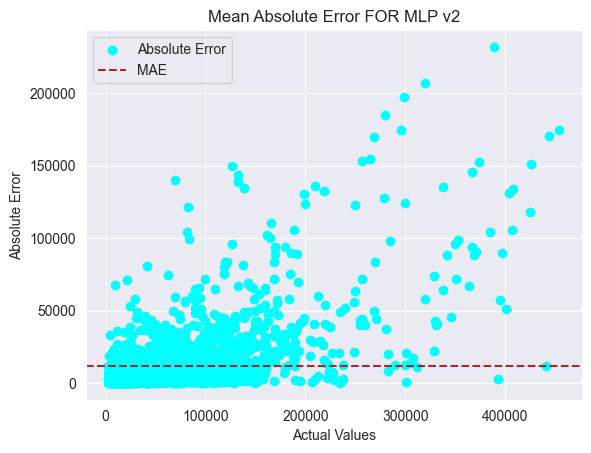

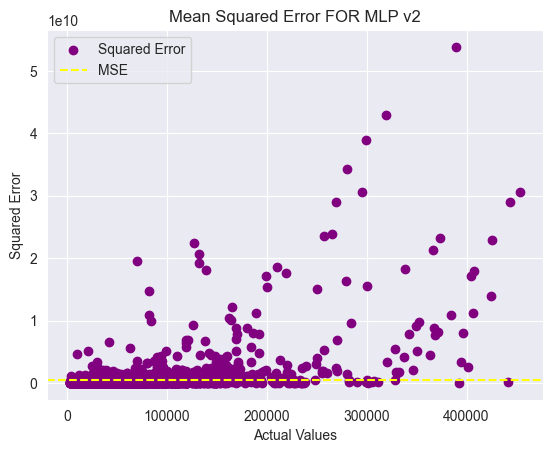

In [49]:
metrics_plots(history_MLP_v2, y_pred_MLP_v2, mae_MLP_v2, mse_MLP_v2, "MLP v2")

Get the best hyperparameters

In [52]:
from sklearn.model_selection import RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasRegressor


def get_hyperparameters():
        model = KerasRegressor(build_fn=LSTM_architecture, verbose=0)
        param_grid = {
            'neurons_lstm': [32, 64, 128],
            'neurons_dense': [16, 32, 64],
            'activation': ['relu'],
            'l2_val': [0.01, 0.001, 0.0001]
        }
        searcher = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=5,
            cv=3,
            n_jobs=-1
        )
        searcher.fit(X_train_3D, y_train_scaled)
        return searcher.best_params_, searcher.best_score_

# Call the function to get the best hyperparameters
best_params, best_score = get_hyperparameters()

print("Best parameters: ", best_params)
print("Best score: ", best_score)

C:\Users\szymo\AppData\Local\Temp\ipykernel_17488\2508389334.py:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=LSTM_architecture, verbose=0)


Best parameters:  {'neurons_lstm': 64, 'neurons_dense': 32, 'l2_val': 0.0001, 'activation': 'relu'}
Best score:  -0.21322791775067648


Every possible combination of param_grid parameters.
TODO: Best parameters:  {'neurons_lstm': 64, 'neurons_dense': 32, 'l2_val': 0.0001, 'activation': 'relu'}
Best score:  -0.21322791775067648 <- completely wrong

In [10]:
from sklearn.model_selection import GridSearchCV

# definiowanie zestawów parametrów do przetestowania
param_grid = {
    'neurons_lstm': [64, 128],
    'neurons_dense1': [32, 64],
    'neurons_dense2': [16, 32],
    'neurons_dense3': [8, 16],
    'neurons_dense4': [8, 16],
    'activation': ['relu', 'tanh'],
    'l2_val': [0.01, 0.001],
    'batch_size': [32, 64]
}


model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=MLP_architecture_v2, epochs=1, verbose=0)

# start Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train_scaled, y_train_scaled)

print(f"Best score: {grid_result.best_score_}")
print(f"Best params: {grid_result.best_params_}")


C:\Users\szymo\AppData\Local\Temp\ipykernel_16708\4125700547.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=MLP_architecture_v2, epochs=1, verbose=0)


KeyboardInterrupt: 

### Possible DEPLOY - docker, github